In [4]:
!pip install datasets sacrebleu --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
from datasets import load_dataset
from sacrebleu import corpus_bleu

import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm
import re
from torch.utils.checkpoint import checkpoint


In [5]:
dataset = load_dataset("opus_books", "en-es")

raw_data = dataset["train"].shuffle(seed=42).select(range(15000))
print(raw_data[0])

# Special tokens
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"
UNK_TOKEN = "<unk>"

# toknize
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z¿¡]+", " ", text)
    return text.strip().split()

en_sentences = [tokenize(x['translation']['en']) for x in raw_data]
es_sentences = [tokenize(x['translation']['es']) for x in raw_data]


es_sentences = [[SOS_TOKEN] + sent + [EOS_TOKEN] for sent in es_sentences]

{'id': '60296', 'translation': {'en': 'Kitty, on the contrary, was more active than usual and even more animated.', 'es': 'Kitty, al contrario, estaba más activa a incluso más animada que nunca.'}}


In [6]:
from collections import Counter
import re

def build_vocab(sentences, min_freq=2):
    counter = Counter()
    for sentence in sentences:
        counter.update(sentence)
    vocab = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + \
            [word for word, freq in counter.items() if freq >= min_freq]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    return vocab, word2idx, idx2word

en_vocab, en_word2idx, en_idx2word = build_vocab(en_sentences)
es_vocab, es_word2idx, es_idx2word = build_vocab(es_sentences)

print(f"English Vocab Size: {len(en_vocab)}")
print(f"Spanish Vocab Size: {len(es_vocab)}")

English Vocab Size: 11121
Spanish Vocab Size: 13268


In [7]:
MAX_LEN_EN = 60
MAX_LEN_ES = 62 

def encode_sentence(sentence, word2idx, max_len, is_target=False):
    ids = [word2idx.get(tok, word2idx[UNK_TOKEN]) for tok in sentence]
    if is_target:
        ids = ids[:max_len]
        ids += [word2idx[PAD_TOKEN]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
        ids += [word2idx[PAD_TOKEN]] * (max_len - len(ids))
    return ids

inputs = [encode_sentence(s, en_word2idx, MAX_LEN_EN) for s in en_sentences]
targets = [encode_sentence(s, es_word2idx, MAX_LEN_ES, is_target=True) for s in es_sentences]

inputs_tensor = torch.tensor(inputs, dtype=torch.long)
targets_tensor = torch.tensor(targets, dtype=torch.long)

print("Inputs shape:", inputs_tensor.shape)
print("Targets shape:", targets_tensor.shape)

Inputs shape: torch.Size([15000, 60])
Targets shape: torch.Size([15000, 62])


In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {'src': self.inputs[idx], 'tgt': self.targets[idx]}

train_len = int(0.8 * len(inputs_tensor))
val_len = int(0.1 * len(inputs_tensor))
test_len = len(inputs_tensor) - train_len - val_len

train_set = TranslationDataset(inputs_tensor[:train_len], targets_tensor[:train_len])
val_set = TranslationDataset(inputs_tensor[train_len:train_len+val_len], targets_tensor[train_len:train_len+val_len])
test_set = TranslationDataset(inputs_tensor[-test_len:], targets_tensor[-test_len:])

BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=en_word2idx[PAD_TOKEN])
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs, (hidden, cell)

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)
    
    def forward(self, hidden, encoder_outputs):
        hidden = hidden[-1].unsqueeze(1)
                hidden_expanded = hidden.expand(-1, encoder_outputs.size(1), -1)
        
        energy = torch.tanh(self.attn(torch.cat((hidden_expanded, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        
        return torch.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers=1, dropout=0.1):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=es_word2idx[PAD_TOKEN])
        self.attention = Attention(hid_dim)
        self.rnn = nn.LSTM(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input, hidden, cell, encoder_outputs):        
        input = input.unsqueeze(1)  # [batch, 1]
        embedded = self.dropout(self.embedding(input))  # [batch, 1, emb_dim]
        
        a = self.attention(hidden, encoder_outputs).unsqueeze(1)  # [batch, 1, seq_len]
        
        weighted = torch.bmm(a, encoder_outputs)  # [batch, 1, hid_dim]
        
        # Concatenate embedded input and weighted context
        rnn_input = torch.cat((embedded, weighted), dim=2)  # [batch, 1, emb_dim + hid_dim]
        
        # Pass through LSTM
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))  # output = [batch, 1, hid_dim]
        
        # Predict next token
        prediction = self.fc_out(torch.cat((output.squeeze(1), weighted.squeeze(1)), dim=1))
        
        return prediction, hidden, cell
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.use_checkpoint = True
    
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_outputs, (hidden, cell) = self.encoder(src)
        
        input = trg[:, 0]
        
        for t in range(1, trg_len):
            if self.use_checkpoint:
                output, hidden, cell = checkpoint(
                    self._decoder_step,
                    input, hidden, cell, encoder_outputs,
                    use_reentrant=False
                )
            else:
                output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
                
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
            
        return outputs
    
    def _decoder_step(self, input, hidden, cell, encoder_outputs):
        """Helper function for checkpointing"""
        return self.decoder(input, hidden, cell, encoder_outputs)


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

INPUT_DIM = len(en_word2idx)
OUTPUT_DIM = len(es_word2idx)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
model = Seq2Seq(encoder, decoder, device)
model.use_checkpoint = True
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=es_word2idx[PAD_TOKEN])

cuda


In [11]:
from torch.cuda.amp import autocast, GradScaler

# Initialize gradient scaler
scaler = GradScaler()

# def train(model, dataloader, optimizer, criterion, device, epoch, total_epochs):
#     model.train()
#     epoch_loss = 0
#     total_batches = len(dataloader)
    
#     progress_bar = tqdm(enumerate(dataloader), total=total_batches, 
#                        desc=f"Epoch {epoch+1}/{total_epochs}")
    
#     for i, batch in progress_bar:
#         src = batch["src"].to(device)
#         trg = batch["tgt"].to(device)
        
#         optimizer.zero_grad()
        
#         # Mixed precision forward pass
#         with autocast():
#             output = model(src, trg)
#             output_dim = output.shape[-1]
#             output = output[:, 1:].reshape(-1, output_dim)  # Skip <sos>
#             trg = trg[:, 1:].reshape(-1)
#             loss = criterion(output, trg)
        
#         # Scaled backward pass
#         scaler.scale(loss).backward()
        
#         # Gradient clipping
#         scaler.unscale_(optimizer)
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
#         # Scaled optimizer step
#         scaler.step(optimizer)
#         scaler.update()
        
#         epoch_loss += loss.item()
        
#         # Update progress bar
#         if (i + 1) % 10 == 0:
#             progress_bar.set_postfix({
#                 'loss': f'{epoch_loss/(i+1):.4f}',
#                 'lr': optimizer.param_groups[0]['lr'],
#                 'scale': f'{scaler.get_scale():.1f}'  # Show current scale factor
#             })
    
#     return epoch_loss / total_batches
def train(model, dataloader, optimizer, criterion, device, epoch, total_epochs):
    model.train()
    epoch_loss = 0
    total_batches = len(dataloader)
    batch_losses = []

    progress_bar = tqdm(enumerate(dataloader), total=total_batches, desc=f"Epoch {epoch+1}/{total_epochs}")

    for i, batch in progress_bar:
        src = batch["src"].to(device)
        trg = batch["tgt"].to(device)

        optimizer.zero_grad()

        with autocast():
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        batch_losses.append(loss.item())

        if (i + 1) % 10 == 0:
            progress_bar.set_postfix({
                'loss': f'{epoch_loss/(i+1):.4f}',
                'lr': optimizer.param_groups[0]['lr'],
                'scale': f'{scaler.get_scale():.1f}'
            })

    return epoch_loss / total_batches, batch_losses



C:\Users\abhis\AppData\Local\Temp\ipykernel_25672\209357084.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            src = batch["src"].to(device)
            trg = batch["tgt"].to(device)
            
            output = model(src, trg, teacher_forcing_ratio=0)
            preds = output.argmax(dim=-1)
            
            for i in range(preds.shape[0]):
                pred_tokens = [es_idx2word[idx.item()] for idx in preds[i] if idx not in [es_word2idx[PAD_TOKEN], es_word2idx[SOS_TOKEN], es_word2idx[EOS_TOKEN]]]
                label_tokens = [es_idx2word[idx.item()] for idx in trg[i] if idx not in [es_word2idx[PAD_TOKEN], es_word2idx[SOS_TOKEN], es_word2idx[EOS_TOKEN]]]
                
                all_preds.append(" ".join(pred_tokens))
                all_labels.append([" ".join(label_tokens)])
    
    bleu = corpus_bleu(all_preds, all_labels)
    return bleu.score

In [ ]:
torch.backends.cudnn.benchmark = True

debugging step because there were cuda errors arising and slow processing on cpu

In [14]:
import torch.utils.benchmark as benchmark

# Get a single batch
sample_batch = next(iter(train_loader))
src_sample = sample_batch["src"].to(device)
trg_sample = sample_batch["tgt"].to(device)

# Benchmark forward pass only
print("=== Forward Pass Benchmark ===")
t0 = benchmark.Timer(
    stmt='model(src, trg)',
    globals={'model': model, 'src': src_sample, 'trg': trg_sample},
    label="Forward Pass"
)
print(t0.timeit(10))

# Benchmark full training step (separate graph each time)
print("\n=== Full Training Step Benchmark ===")
t1 = benchmark.Timer(
    stmt='''
        optimizer.zero_grad()
        output = model(src, trg)
        loss = criterion(output[:,1:].reshape(-1, output.shape[-1]), trg[:,1:].reshape(-1))
        loss.backward()
        optimizer.step()
    ''',
    globals={'model': model, 'criterion': criterion, 'optimizer': optimizer, 
             'src': src_sample, 'trg': trg_sample},
    label="Full Training Step"
)
print(t1.timeit(5))

=== Forward Pass Benchmark ===
Forward Pass
  479.72 ms
  1 measurement, 10 runs , 1 thread

=== Full Training Step Benchmark ===
Full Training Step
  7.36 s
  1 measurement, 5 runs , 1 thread


In [15]:
# EPOCHS = 3
# best_bleu = 0

# for epoch in range(EPOCHS):
#     start_time = time.time()
    
#     # Train
#     train_loss = train(model, train_loader, optimizer, criterion, device, epoch, EPOCHS)
    
#     # Evaluate
#     val_bleu = evaluate(model, val_loader, device)
    
#     # Print epoch summary
#     print(f"\nEpoch {epoch+1} Summary:")
#     print(f"  Train Loss: {train_loss:.8f}")
#     print(f"  Val BLEU: {val_bleu:.8f}")
#     print(f"  Time: {time.time() - start_time:.8f}s")
    
#     # Save best model
#     if val_bleu > best_bleu:
#         best_bleu = val_bleu
#         torch.save(model.state_dict(), "best_seq2seq_model.pt")
#         print("  Best model saved!")
EPOCHS = 3
all_train_batch_losses = []
epoch_train_losses = []
val_bleus = []
best_bleu = 0

for epoch in range(EPOCHS):
    start_time = time.time()
    
    # Train
    train_loss, batch_losses = train(model, train_loader, optimizer, criterion, device, epoch, EPOCHS)
    epoch_train_losses.append(train_loss)
    all_train_batch_losses.extend(batch_losses)
    
    # Evaluate
    val_bleu = evaluate(model, val_loader, device)
    val_bleus.append(val_bleu)
    
    # Print
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.8f}")
    print(f"  Val BLEU: {val_bleu:.8f}")
    print(f"  Time: {time.time() - start_time:.2f}s")
    
    if val_bleu > best_bleu:
        best_bleu = val_bleu
        torch.save(model.state_dict(), "best_seq2seq_model.pt")
        print("  Best model saved!")


Epoch 1/3:   0%|          | 0/94 [00:00<?, ?it/s]C:\Users\abhis\AppData\Local\Temp\ipykernel_25672\209357084.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]



Epoch 1 Summary:
  Train Loss: 6.64707059
  Val BLEU: 5.99767905
  Time: 403.59s
  Best model saved!


Evaluating: 100%|██████████| 12/12 [00:30<00:00,  2.57s/it]



Epoch 2 Summary:
  Train Loss: 6.39701451
  Val BLEU: 61.47881530
  Time: 406.74s
  Best model saved!


Evaluating: 100%|██████████| 12/12 [00:33<00:00,  2.81s/it]


Epoch 3 Summary:
  Train Loss: 6.26436980
  Val BLEU: 16.84320988
  Time: 404.01s


In [16]:
model.load_state_dict(torch.load("best_seq2seq_model.pt"))
test_bleu = evaluate(model, test_loader, device)
print(f"\nFinal Test BLEU Score: {test_bleu:.4f}")


C:\Users\abhis\AppData\Local\Temp\ipykernel_25672\1853418835.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_seq2seq_model.pt"))
E


Final Test BLEU Score: 67.2432


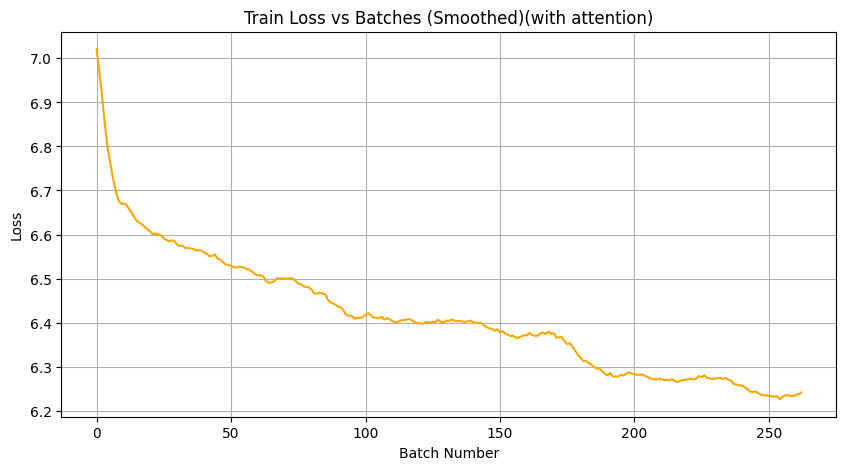

In [23]:
def moving_average(data, window_size=20):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_losses = moving_average(all_train_batch_losses, window_size=20)

plt.figure(figsize=(10, 5))
plt.plot(smoothed_losses, color='orange')
plt.title("Train Loss vs Batches (Smoothed)(with attention)")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


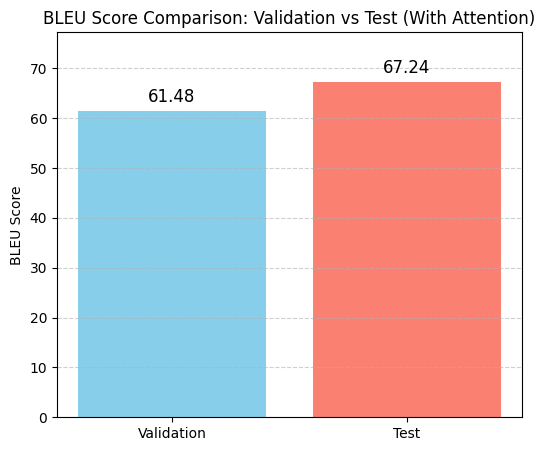

In [19]:
import matplotlib.pyplot as plt

val_bleu = 61.4788
test_bleu = 67.2432

labels = ['Validation', 'Test']
scores = [val_bleu, test_bleu]

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, scores, color=['skyblue', 'salmon'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.title("BLEU Score Comparison: Validation vs Test (With Attention)")
plt.ylabel("BLEU Score")
plt.ylim(0, max(scores) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


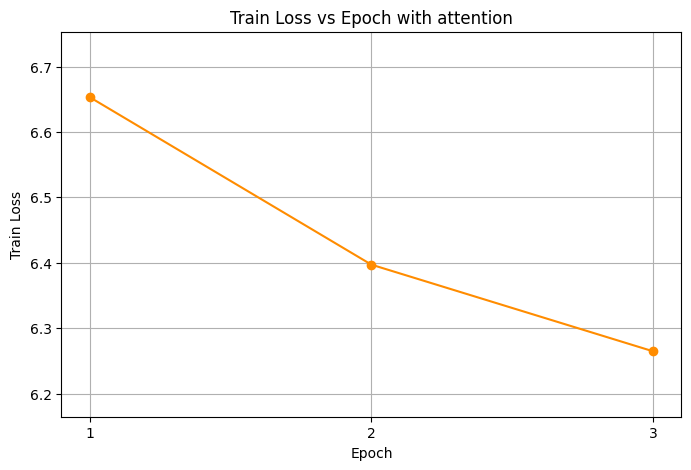

In [22]:
import matplotlib.pyplot as plt

train_losses = [6.6534, 6.3971, 6.2645]
epochs = [1, 2, 3]


plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='darkorange')
plt.title("Train Loss vs Epoch with attention")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.grid(True)
plt.xticks(epochs)
plt.ylim(min(train_losses) - 0.1, max(train_losses) + 0.1)
plt.show()


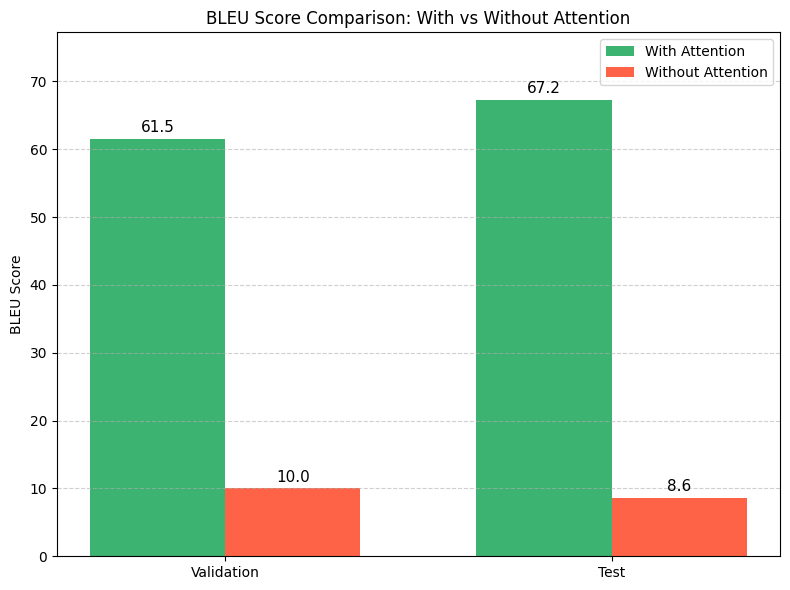

In [21]:
import matplotlib.pyplot as plt

# BLEU scores
val_bleu_with_attn = 61.4788
test_bleu_with_attn = 67.2432
val_bleu_no_attn = 10.0127
test_bleu_no_attn = 8.5566

# Data
labels = ['Validation', 'Test']
with_attn_scores = [val_bleu_with_attn, test_bleu_with_attn]
no_attn_scores = [val_bleu_no_attn, test_bleu_no_attn]

x = range(len(labels))
width = 0.35

# Plot
plt.figure(figsize=(8, 6))
plt.bar([i - width/2 for i in x], with_attn_scores, width=width, label='With Attention', color='mediumseagreen')
plt.bar([i + width/2 for i in x], no_attn_scores, width=width, label='Without Attention', color='tomato')

# Annotate bars
for i in x:
    plt.text(i - width/2, with_attn_scores[i] + 1, f'{with_attn_scores[i]:.1f}', ha='center', fontsize=11)
    plt.text(i + width/2, no_attn_scores[i] + 1, f'{no_attn_scores[i]:.1f}', ha='center', fontsize=11)

# Style
plt.xticks(x, labels)
plt.ylabel("BLEU Score")
plt.title("BLEU Score Comparison: With vs Without Attention")
plt.legend()
plt.ylim(0, max(with_attn_scores) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
